In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
class LNN:
    def __init__(self, N, v = None, w = None, sigmaS = 1., sigmaI = 1., sigmaG = 1., nonlinearity = None):
        self.N = N
        if v is None:
            self.v = 0
        else:
            self.v = v
        
        if w is None:
            self.w = 0
        else:
            self.w = w
        
        if nonlinearity is None:
            self.nonlinearity = self.squared
        else:
            self.nonlinearity = nonlinearity
        
        self.sigmaS = sigmaS
        self.sigmaI = sigmaI
        self.sigmaG = sigmaG
    
    def squared(self,x):
        return x**2

    def simulate(self,trials):
        s = np.random.normal(loc = 0., scale = sigmaG, size = trials)
        injected_noise = np.random.normal(loc = 0., scale = sigmaI, size = trials)
        private_noise = np.random.normal(loc = 0., scale = sigmaG, size = (self.N, trials))
        l = np.outer(self.v, s) + np.outer(self.w, injected_noise) + private_noise
        r = self.nonlinearity(l)
        return r
    
    def mutual(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vw = np.sum(v * w)
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        sigma_stim = self.sigmaG**2 + self.sigmaS**2 * v2
        kappa = sigma_inj * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vw**2
        I1 = 0.5 * np.log(kappa/(self.sigmaG**2 * sigma_inj))
        
        w_outer = np.outer(w, w)
        v_outer = np.outer(v, v)
        wv_outer = np.outer(w, v)
        
        B = -(self.sigmaI**2 * self.sigmaS**2 * vw)**2/(2 * self.sigmaG**2 * kappa * sigma_inj) * w_outer \
            + (self.sigmaI * self.sigmaS**2 * vw)/(kappa * self.sigmaG**2) * wv_outer \
            - (self.sigmaS**2 * sigma_inj)/(2 * self.sigmaG**2 * kappa) * v_outer
        A = 1./(2 * self.sigmaG**2) * np.identity(self.N) - sigma_stim/(2 * self.sigmaG**2 * kappa) * w_outer \
            + (self.sigmaI * self.sigmaS**2 * vw)/(kappa * self.sigmaG**2) * wv_outer \
            - (self.sigmaS**2 * sigma_inj)/(2 * self.sigmaG**2 * kappa) * v_outer
        
        I2 = np.trace(np.dot(B, np.linalg.inv(A)))/(self.sigmaG**(self.N - 2.) * 2**(self.N/2.) * np.sqrt(kappa * np.linalg.det(A)))
        
        C = self.sigmaG**2 * kappa * sigma_inj * (self.sigmaG**2 * v2 + self.sigmaI**2 * (v2 * w2 - vw**2))
        D = 1./(2 * self.sigmaG**2) * np.identity(self.N) \
            -(1./(2 * self.sigmaG**2 * kappa)) * (-sigma_stim * w_outer + 2 * self.sigmaI * self.sigmaS**2 * vw * wv_outer - self.sigmaS**2 * sigma_inj * v_outer)
        gamma = (2 * self.sigmaG**2 + self.sigmaS**2 * v2) * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vw**2
        E = gamma * (-self.sigmaI**2 * w_outer + 2 * self.sigmaI * vw * wv_outer - sigma_inj**2 * v_outer)
        I3 = -self.sigmaS**2/(2 * 2**(self.N/2) * self.sigmaG**self.N * kappa**(2.5) * sigma_inj * np.sqrt(np.linalg.det(D))) \
            * (C + np.trace(np.dot(E, np.linalg.inv(D))))
        return I1

In [20]:
ns1 = np.arange(200)
muts1 = np.zeros(ns1.shape)

In [21]:
for idx, n in enumerate(ns1):
    v = np.ones(n)
    w = np.ones(n)
    lnn = LNN(n, v = v, w = w)
    muts1[idx] = lnn.mutual()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


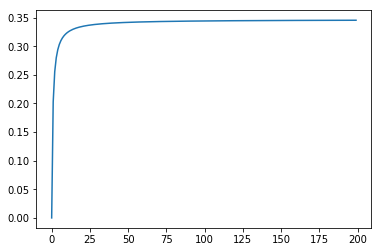

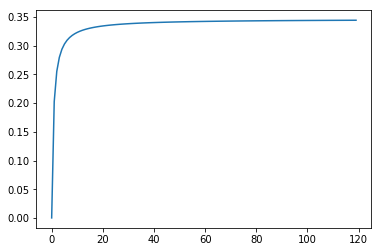

In [22]:
plt.plot(ns1, muts1)
plt.show()
plt.plot(ns1[:120], muts1[:120])
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


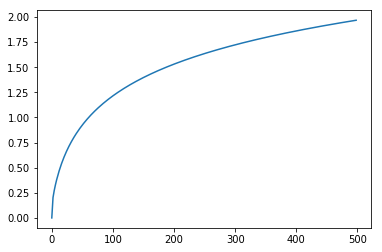

In [24]:
ns2 = np.arange(0, 500, 2)
muts2 = np.zeros(ns2.shape)
for idx, n in enumerate(ns2):
    v = np.ones(n)
    w = np.concatenate((np.ones(n/2), 2 * np.ones(n/2)))
    lnn = LNN(n, v = v, w = w)
    muts2[idx] = lnn.mutual()
plt.plot(ns2, muts2)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


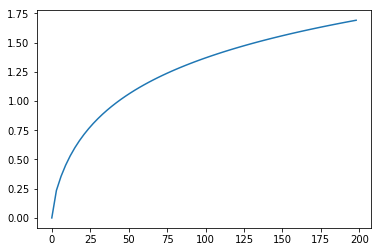

In [25]:
ns3 = np.arange(0, 200, 3)
muts3 = np.zeros(ns3.shape)
for idx, n in enumerate(ns3):
    v = np.ones(n)
    w = np.concatenate((np.ones(n/3), 2 * np.ones(n/3), 3 * np.ones(n/3)))
    lnn = LNN(n, v = v, w = w)
    muts3[idx] = lnn.mutual()
plt.plot(ns3, muts3)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


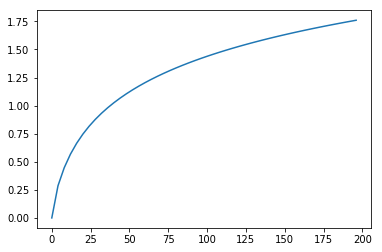

In [26]:
ns4 = np.arange(0, 200, 4)
muts4 = np.zeros(ns4.shape)
for idx, n in enumerate(ns4):
    v = np.ones(n)
    w = np.concatenate((np.ones(n/4), 2 * np.ones(n/4), 3 * np.ones(n/4), 4 * np.ones(n/4)))
    lnn = LNN(n, v = v, w = w)
    muts4[idx] = lnn.mutual()
plt.plot(ns4, muts4)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


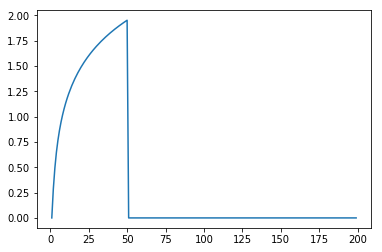

In [29]:
nsN = np.arange(1, 200, 1)
mutsN = np.zeros(nsN.shape)
for idx, n in enumerate(ns4):
    v = np.ones(n)
    w = np.arange(1, n+1)
    lnn = LNN(n, v = v, w = w)
    mutsN[idx] = lnn.mutual()
plt.plot(nsN, mutsN)

In [28]:
mutsN

array([ 0.        ,  0.28667299,  0.49254423,  0.64796293,  0.76785506,
        0.86489757,  0.94628488,  1.01632881,  1.0777902 ,  1.1325364 ,
        1.18188719,  1.22680902,  1.26803044,  1.30611416,  1.34150373,
        1.37455493,  1.40555748,  1.43475042,  1.4623333 ,  1.48847437,
        1.51331684,  1.53698361,  1.55958091,  1.5812012 ,  1.60192545,
        1.62182497,  1.64096287,  1.65939532,  1.67717245,  1.69433926,
        1.71093627,  1.72700008,  1.74256388,  1.75765787,  1.77230956,
        1.78654415,  1.80038472,  1.8138525 ,  1.82696704,  1.83974639,
        1.85220727,  1.86436516,  1.87623445,  1.88782851,  1.89915983,
        1.91024005,  1.92108005,  1.93169002,  1.94207954,  1.95225757,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [30]:
v1 = 3
s = 5
w1 = 2
sigmaI = 4
sigmaG = 1
xiI = np.random.normal(size = 10000)
xii = np.random.normal(size = 10000)
l1 = v1 * s + w1 * sigmaI*xiI + sigmaG*xii 

In [33]:
print(np.mean(l1))
print(np.std(l1))

14.9463876247
8.08393127409


In [36]:
np.sqrt(sigmaG**2 + w1**2 * sigmaI**2)

8.0622577482985491